In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob, os
from datetime import datetime
import json
import SimpleITK as sitk
from MRLCinema.readcine.readcines import readcines, CineImage, SliceDirection
from MRLCinema.readcine.read_mask import read_mask, read_patient_ID
from MRLCinema.registration.create_mask import mask_dilation
from MRLCinema.registration.create_mask import create_mask_2d
from MRLCinema.registration.crop import crop_sequence, crop_image, find_crop_box
from MRLCinema.registration.sequence import cine_sequence_rigid_registration
from U2Dose.patient.Roi import Roi
from U2Dose.dicomio.rtstruct import RtStruct
from U2Dose.dicomio.rtplan import RtPlan
from U2Dose.geometry.Grid3D import Grid3D
import pydicom


In [2]:
import SimpleITK as sitk

'Elastix' in dir(sitk)

True

In [3]:
def create_grid(transversal, coronal, sagittal):

    x_00 = min(transversal.image.GetOrigin()[0], coronal.image.GetOrigin()[0])
    y_00 = min(transversal.image.GetOrigin()[1], sagittal.image.GetOrigin()[0])
    z_00 = min(coronal.image.GetOrigin()[1], sagittal.image.GetOrigin()[1])
    pos_000 = np.array([x_00, y_00, z_00])
        
    s_x = min(transversal.image.GetSpacing()[0], coronal.image.GetSpacing()[0])
    s_y = min(transversal.image.GetSpacing()[1], sagittal.image.GetSpacing()[0])
    s_z = min(coronal.image.GetSpacing()[1], sagittal.image.GetSpacing()[1])
    spacing = np.array([s_x, s_y, s_z])

    d_x = max(transversal.image.GetSize()[0], coronal.image.GetSize()[0])
    d_y = max(transversal.image.GetSize()[1], sagittal.image.GetSize()[0])
    d_z = max(coronal.image.GetSize()[1], sagittal.image.GetSize()[1])
    dim = np.array([d_x, d_y, d_z])
    
    
    return Grid3D(pos_000, spacing, dim)

def find_structure_set(patient_ID, timestamp) -> RtStruct|None:
    patient_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
    rtss_filenames = glob.glob(os.path.join(patient_root, patient_ID, '*', 'RS*.dcm'))
    for filename in rtss_filenames:
        rtss_dcm = pydicom.dcmread(filename)
        rtss_study_date = datetime(int(rtss_dcm.StudyDate[0:4]), int(rtss_dcm.StudyDate[4:6]), int(rtss_dcm.StudyDate[6:8])).date()
        
        if rtss_study_date == timestamp.date():
            rtss = RtStruct(filename)
            rtss.parse()
            return rtss
    return None

def find_plan(patient_ID, timestamp) -> RtStruct|None:
    patient_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
    rtplan_filenames = glob.glob(os.path.join(patient_root, patient_ID, '*', 'RP*.dcm'))
    for filename in rtplan_filenames:
        rtplan_dcm = pydicom.dcmread(filename)
        rtplan_study_date = datetime(int(rtplan_dcm.StudyDate[0:4]), int(rtplan_dcm.StudyDate[4:6]), int(rtplan_dcm.StudyDate[6:8])).date()
        
        if rtplan_study_date == timestamp.date():
            rtplan = RtPlan(filename)
            rtplan.parse()
            return rtplan
    return None


def construct_zmm(rtss, grid):
    return Roi.from_rtstruct(rtss, name='Z_MM', grid=grid)

def remove_center_cross(image:sitk.Image, block_size:int) -> sitk.Image:
    dim = image.GetSize()
    center = [int(dim[1]/2), int(dim[0]/2)]
    #image_copy = sitk.Image(image)
    #image_copy[center[0]-block_size:center[0]+block_size] = 0
    #image_copy[:,center[1]-block_size:center[1]+block_size] = 0
    #return image_copy

    np_image = sitk.GetArrayFromImage(image)
    np_image[center[0]-block_size:center[0]+block_size] = 0
    np_image[:,center[1]-block_size:center[1]+block_size] = 0

    image_copy = sitk.GetImageFromArray(np_image)
    image_copy.SetOrigin(image.GetOrigin())
    image_copy.SetSpacing(image.GetSpacing())
    image_copy.SetDirection(image.GetDirection())

    return image_copy




In [4]:
filename = '/home/david/source/QAckis/QAckis/TestData/cine/example.bin'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/cines'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112811114308006'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.16236.2024102909043045002'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112808532524002'


cine_directory = os.path.join(path, 'TwoDImages')

import time
start = time.time()
cines = readcines(cine_directory, max_n=500)
print(time.time()-start, len(cines))

time_sorted_cines = sorted(cines, key=lambda cine: cine.timestamp)

time_sorted_transversal = list(filter(lambda cine: cine.direction == SliceDirection.TRANSVERSAL, time_sorted_cines))
time_sorted_coronal = list(filter(lambda cine: cine.direction == SliceDirection.CORONAL, time_sorted_cines))
time_sorted_sagittal = list(filter(lambda cine: cine.direction == SliceDirection.SAGITTAL, time_sorted_cines))

print(time.time()-start, len(cines))

for i in range(10):
    print(i, cines[i].direction, "   ", cines[i].timestamp.time())

# print()

# for i in range(10):
#     print(i, time_sorted_coronal[i].direction, "   ", time_sorted_coronal[i].timestamp.time())

# for i in range(10):
#     print(i, time_sorted_sagittal[i].direction, "   ", time_sorted_sagittal[i].timestamp.time())

len(time_sorted_transversal), len(time_sorted_coronal), len(time_sorted_sagittal)

26.344324111938477 500
26.345065355300903 500
0 SliceDirection.CORONAL     09:35:09.211025
1 SliceDirection.CORONAL     09:25:32.718959
2 SliceDirection.TRANSVERSAL     09:30:42.408019
3 SliceDirection.TRANSVERSAL     09:25:57.872829
4 SliceDirection.SAGITTAL     09:32:50.861026
5 SliceDirection.TRANSVERSAL     09:27:07.769961
6 SliceDirection.SAGITTAL     09:32:13.128989
7 SliceDirection.TRANSVERSAL     09:30:37.460015
8 SliceDirection.TRANSVERSAL     09:30:10.861950
9 SliceDirection.CORONAL     09:30:38.903016


(177, 162, 161)

In [5]:
(time_sorted_transversal[10].timestamp - time_sorted_transversal[0].timestamp).seconds

38

In [6]:
grid = create_grid(time_sorted_transversal[0], time_sorted_coronal[0], time_sorted_sagittal[0])

patient_ID = read_patient_ID(path)
print(patient_ID)

print('find rtss')
rtss = find_structure_set(patient_ID, time_sorted_cines[0].timestamp)
print(rtss.all_roi_names())

print('find rtplan')
rtplan = find_plan(patient_ID, time_sorted_cines[0].timestamp)

 

grid.pos_000, grid.spacing, grid.dim
rtss.all_roi_names()







194202130656
find rtss
['PTVT_42.7', 'Z_MM', 'External', 'Z_External', 'Rectum', 'PenileBulb', 'Femur_R(Upper)', 'Femur_L(Upper)', 'Bladder', 'Z_Bone', 'CTVT_42.7', 'Z1-Bridge', 'Z10-Couch Support', 'Z2a-Bridge', 'Z2b-Bridge', 'Z3-Bridge', 'Z4-Couch Support', 'Z5-Hard-plate', 'Z6-Couch Support', 'Z7-Couch Support', 'Z8-Mattress']
find rtplan


['PTVT_42.7',
 'Z_MM',
 'External',
 'Z_External',
 'Rectum',
 'PenileBulb',
 'Femur_R(Upper)',
 'Femur_L(Upper)',
 'Bladder',
 'Z_Bone',
 'CTVT_42.7',
 'Z1-Bridge',
 'Z10-Couch Support',
 'Z2a-Bridge',
 'Z2b-Bridge',
 'Z3-Bridge',
 'Z4-Couch Support',
 'Z5-Hard-plate',
 'Z6-Couch Support',
 'Z7-Couch Support',
 'Z8-Mattress']

In [7]:
print('constrict z_mm volume')
z_mm = construct_zmm(rtss, grid)
print('constrict ctv volume')
ctv = Roi.from_rtstruct(rtss, name='CTVT_42.7', grid=grid)
print('constrict rectum volume')
rectum = Roi.from_rtstruct(rtss, name='Rectum', grid=grid)
#bladder = Roi.from_rtstruct(rtss, name='Bladder', grid=grid)
#external = Roi.from_rtstruct(rtss, name='External', grid=grid)
#union = z_mm.mask + 2*rectum.mask + 3*bladder.mask

#print('mask dilation')
#registration_mask_3d = mask_dilation(z_mm.mask, grid.pos_000, grid.spacing, dilation_distance=10)


constrict z_mm volume
constrict ctv volume
constrict rectum volume


(50.0, 275.0)

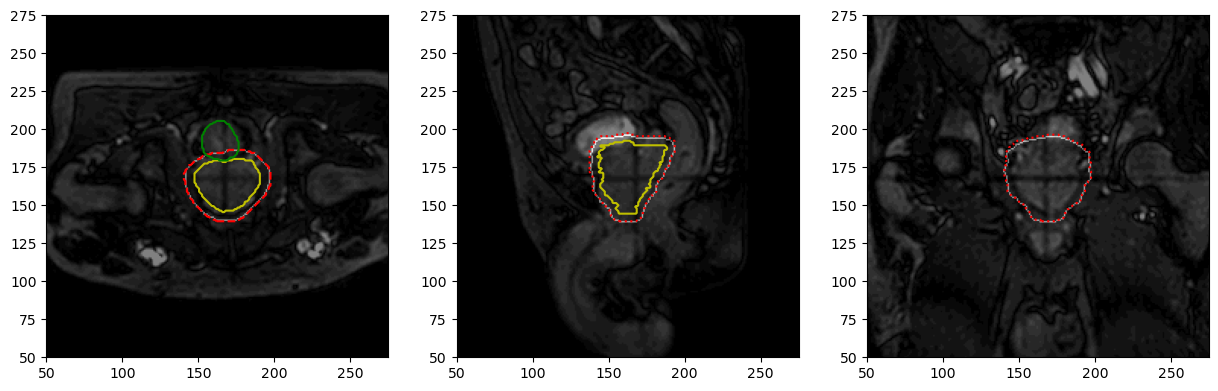

In [8]:

f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 10))

ax4.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].image)[:,:].T, cmap='gray')
ax4.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].mask)[:,:].T, cmap='gray', alpha=0.5)
ax4.contour(z_mm.mask[:,:,168].T, levels=[0.5], colors='r', linestyles='dashed')
ax4.contour(ctv.mask[:,:,168].T, levels=[0.5], colors='y')
ax4.contour(rectum.mask[:,:,168].T, levels=[0.5], colors='g')
ax4.set_xlim([50, 275])
ax4.set_ylim([50, 275])

ax5.imshow(sitk.GetArrayFromImage(time_sorted_sagittal[0].image).swapaxes(0, 1), cmap='gray')
ax5.imshow(sitk.GetArrayFromImage(time_sorted_sagittal[0].mask).swapaxes(0, 1), cmap='gray', alpha=0.5)
ax5.contour(z_mm.mask[168,:,:].T, levels=[0.5], colors='r', linestyles='dotted')
ax5.contour(ctv.mask[168,:,:].T, levels=[0.5], colors='y')
ax5.set_xlim([50, 275])
ax5.set_ylim([50, 275])

ax6.imshow(sitk.GetArrayFromImage(time_sorted_coronal[0].image).swapaxes(0, 1), cmap='gray')
ax6.imshow(sitk.GetArrayFromImage(time_sorted_coronal[0].mask).swapaxes(0, 1), cmap='gray', alpha=0.5)
ax6.contour(z_mm.mask[:,168,:].T, levels=[0.5], colors='r', linestyles='dotted')
ax6.set_xlim([50, 275])
ax6.set_ylim([50, 275])



#ax6.contour(rectum.mask[168,:,:].T, levels=[0.5], colors='g')
#ax6.contour(bladder.mask[168,:,:].T, levels=[0.5], colors='y')

#X-axis: Increases from the patient's right to left.
#Y-axis: Increases from the patient's anterior (front) to posterior (back).
#Z-axis: Increases from the patient's feet to head12.

(0.0, 80.0)

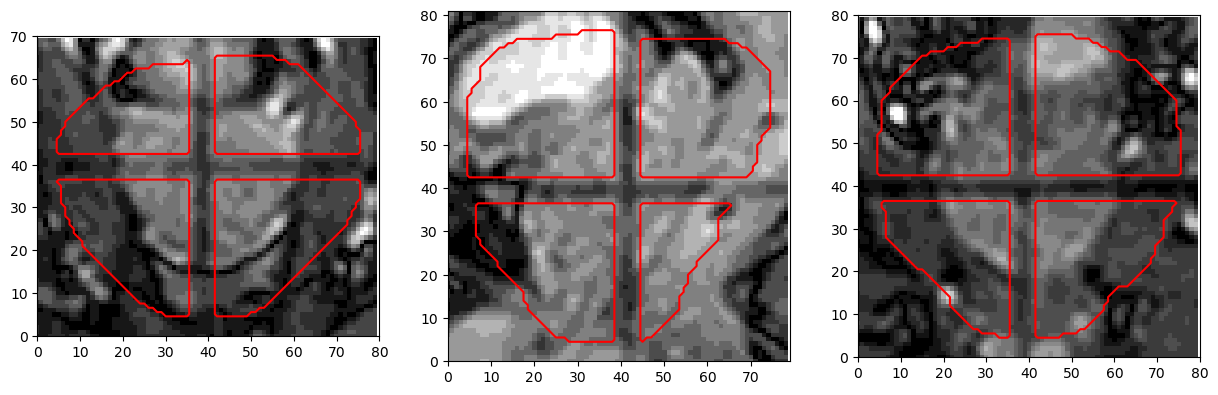

In [9]:
#
# Crop images
#

pos_000 = grid.pos_000

mask_transversal = create_mask_2d(z_mm.mask, grid.pos_000, grid.spacing, SliceDirection.TRANSVERSAL)

dilation_distance = 10
mask_transversal = mask_dilation(mask_transversal, dilation_distance=dilation_distance)
mask_transversal = remove_center_cross(mask_transversal, 3)
crop_box = find_crop_box(mask_transversal, m=5)
cines_transversal_cropped = crop_sequence(time_sorted_transversal, crop_box)
mask_transversal_cropped = crop_image(mask_transversal, crop_box)
mask_transversal_cropped = sitk.Cast(mask_transversal_cropped, sitk.sitkUInt8)


mask_sagittal = create_mask_2d(z_mm.mask, grid.pos_000, grid.spacing, SliceDirection.SAGITTAL)
mask_sagittal = mask_dilation(mask_sagittal, dilation_distance=dilation_distance)
mask_sagittal = remove_center_cross(mask_sagittal, 3)
crop_box = find_crop_box(mask_sagittal, m=5)
cines_sagittal_cropped = crop_sequence(time_sorted_sagittal, crop_box)
mask_sagittal_cropped = crop_image(mask_sagittal, crop_box)
mask_sagittal_cropped = sitk.Cast(mask_sagittal_cropped, sitk.sitkUInt8)


mask_coronal = create_mask_2d(z_mm.mask, grid.pos_000, grid.spacing, SliceDirection.CORONAL)
mask_coronal = mask_dilation(mask_coronal, dilation_distance=dilation_distance)
mask_coronal = remove_center_cross(mask_coronal, 3)
crop_box = find_crop_box(mask_coronal, m=5)
cines_coronal_cropped = crop_sequence(time_sorted_coronal, crop_box)
mask_coronal_cropped = crop_image(mask_coronal, crop_box)
mask_coronal_cropped = sitk.Cast(mask_coronal_cropped, sitk.sitkUInt8)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(sitk.GetArrayFromImage(cines_transversal_cropped[10]).T, cmap='gray')
ax1.contour(sitk.GetArrayFromImage(mask_transversal_cropped).T, levels=[0.5], colors='r')

ax2.imshow(sitk.GetArrayFromImage(cines_sagittal_cropped[10]).T, cmap='gray')
ax2.contour(sitk.GetArrayFromImage(mask_sagittal_cropped).T, levels=[0.5], colors='r')

ax3.imshow(sitk.GetArrayFromImage(cines_coronal_cropped[10]).T, cmap='gray')
ax3.contour(sitk.GetArrayFromImage(mask_coronal_cropped).T, levels=[0.5], colors='r')


sz = mask_transversal_cropped.GetSize()
ax1.set_ylim([0, sz[0]])
ax1.set_xlim([0, sz[1]])

sz = mask_sagittal_cropped.GetSize()
ax2.set_ylim([0, sz[0]])
ax2.set_xlim([0, sz[1]])

sz = mask_coronal_cropped.GetSize()
ax3.set_ylim([0, sz[0]])
ax3.set_xlim([0, sz[1]])



In [10]:
# import time

# start = time.time()
# registered_transversal_sequence = cine_sequence_rigid_registration(time_sorted_transversal, mask_transversal)
# motion_trace_transversal = [reg_cine[1].GetParameters() for reg_cine in registered_transversal_sequence]

# registered_coronal_sequence = cine_sequence_rigid_registration(time_sorted_coronal, mask_coronal)
# motion_trace_coronal = [reg_cine[1].GetParameters() for reg_cine in registered_coronal_sequence]

# registered_sagittal_sequence = cine_sequence_rigid_registration(time_sorted_sagittal, mask_sagittal)
# motion_trace_sagittal = [reg_cine[1].GetParameters() for reg_cine in registered_sagittal_sequence]
# stop = time.time()
# time_to_reg  = stop-start

# print('Registration time:', time_to_reg)
# print('Registration time per image:', time_to_reg / len(cines))



In [11]:
((-48.25299912691116, -76.64499884843826),
 (-72.55299931764603, -76.64499884843826))

print('grd 000', grid.pos_000)
print(time_sorted_transversal[0].image.GetOrigin(), mask_transversal.GetOrigin())
print(time_sorted_sagittal[0].image.GetOrigin(), mask_sagittal.GetOrigin())
print(time_sorted_coronal[0].image.GetOrigin(), mask_coronal.GetOrigin())

grd 000 [-216.41499633 -181.0149948  -236.2129963 ]
(-216.4149963259697, -181.0149948000908) (-216.4149963259697, -181.0149948000908)
(-181.0149948000908, -236.2129963040352) (-181.0149948000908, -236.2129963040352)
(-216.4149963259697, -236.2129963040352) (-216.4149963259697, -236.2129963040352)


In [12]:
from MRLCinema.registration.group import group_registration_elastix
import time
start = time.time()
resultImage, transformParameterMap_transversal = group_registration_elastix(cines_transversal_cropped, mask_transversal_cropped)
resultImage, transformParameterMap_sagittal = group_registration_elastix(cines_sagittal_cropped, mask_sagittal_cropped)
resultImage, transformParameterMap_coronal = group_registration_elastix(cines_coronal_cropped, mask_coronal_cropped)
#end = time.time()
#print(end - start)

#
# Save the transformation parameters
#
#filename_transversal = '/home/david/source/MRLCinema/transform_parameter_map_transversal.txt'
#sitk.WriteParameterFile(transformParameterMap_transversal[0], filename_transversal)
#filename_sagittal = '/home/david/source/MRLCinema/transform_parameter_map_sagittal.txt'
#sitk.WriteParameterFile(transformParameterMap_sagittal[0], filename_sagittal)
#filename_coronal = '/home/david/source/MRLCinema/transform_parameter_map_coronal.txt'
#sitk.WriteParameterFile(transformParameterMap_coronal[0], filename_coronal)


#resultImage, transformParameterMap_transversal = group_registration_elastix(cines_transversal_cropped, mask_transversal_cropped, filename_transversal)
#resultImage, transformParameterMap_sagittal = group_registration_elastix(cines_sagittal_cropped, mask_sagittal_cropped, filename_sagittal)
#resultImage, transformParameterMap_coronal = group_registration_elastix(cines_coronal_cropped, mask_coronal_cropped, filename_coronal)




image info (-50.27099913358688, -13.572997629642487, 0.0) (1.2979999780654907, 1.2979999780654907, 1.0) (70, 80, 177) 6 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
mask info (-50.27099913358688, -13.572997629642487, 0.0) (1.2979999780654907, 1.2979999780654907, 1.0) (70, 80, 177) 1 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

start parameter map
ParameterObject (0x427ea1f0)
  RTTI typeinfo:   elastix::ParameterObject
None
end parameter map

  Reference Count: 1
  Modified Time: 26219
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (AutomaticTransformInitialization "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 3)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (ImageSampler "RandomCoordinate")
  (Interpolator "LinearInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "VarianceOverLastDimensionMetric")
  (MovingImagePyram

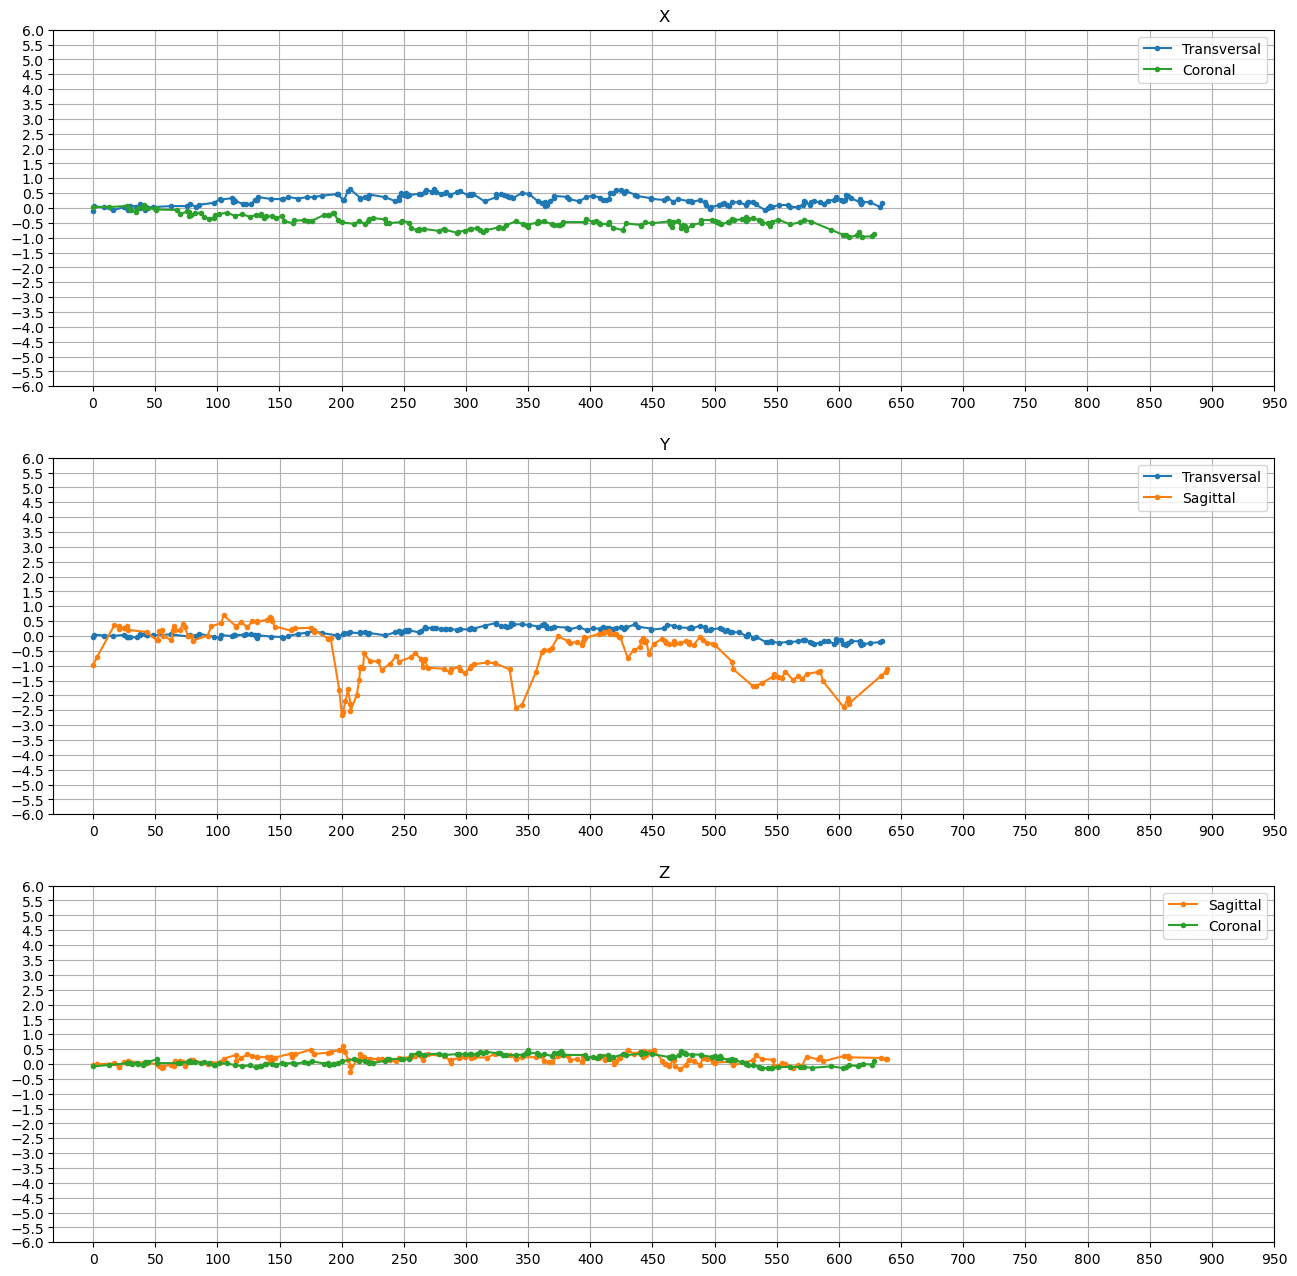

In [13]:


def parameter_map_to_displacements(transform_parameter_map, reset_first=True):
    """ Extracts the displacements from a transform parameter map.
    Two parameters per displacement, one for each direction.
    """
    transform_parameters = transform_parameter_map['TransformParameters']
    even = transform_parameters[::2]
    odd = transform_parameters[1::2]
    displacements = np.zeros([len(even), 2])
    displacements[:,0] = even
    displacements[:,1] = odd
    if reset_first:
        displacements[:,0] -= np.mean(displacements[0:10,0])
        displacements[:,1] -= np.mean(displacements[0:10,1])
    
    return displacements

displacements_transversal = parameter_map_to_displacements(transformParameterMap_transversal[0])
displacements_sagittal = parameter_map_to_displacements(transformParameterMap_sagittal[0])
displacements_coronal = parameter_map_to_displacements(transformParameterMap_coronal[0])

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40/2.54, 40/2.54))
t_transversal =[(cine.timestamp - time_sorted_transversal[0].timestamp).seconds for cine in time_sorted_transversal] 
t_sagittal = [(cine.timestamp - time_sorted_sagittal[0].timestamp).seconds for cine in time_sorted_sagittal]
t_coronal = [(cine.timestamp - time_sorted_coronal[0].timestamp).seconds for cine in time_sorted_coronal] 

ax1.plot(t_transversal, displacements_transversal[:,0], label='Transversal', color='C0', marker='o', markersize=3)
ax2.plot(t_transversal, displacements_transversal[:,1], label='Transversal', color='C0', marker='o', markersize=3)
#ax2.scatter(t_transversal, displacements_transversal[:,1], color='C0')

ax2.plot(t_sagittal, displacements_sagittal[:,0], label='Sagittal', color='C1', marker='o', markersize=3)
ax3.plot(t_sagittal, displacements_sagittal[:,1], label='Sagittal', color='C1', marker='o', markersize=3)

ax1.plot(t_coronal, displacements_coronal[:,0], label='Coronal', color='C2', marker='o', markersize=3)
ax3.plot(t_coronal, displacements_coronal[:,1], label='Coronal', color='C2', marker='o', markersize=3)

ax1.set_title('X')
ax2.set_title('Y')   
ax3.set_title('Z')

for ax in [ax1, ax2, ax3]:
    ax.legend()
    ax.set_ylim([-6,6])
    ax.grid()
    ax.set_xticks(np.arange(0, 1000, 50)) 
    ax.set_yticks(np.arange(-6, 6.1, 0.5)) 


#[[p, transformParameterMap[p]] for p in transformParameterMap]


#t_coronal

In [14]:
len(cines_transversal_cropped)

177

In [15]:
import ipywidgets

def display_images_with_alpha(alpha, fixed, moving, registered):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20/2.54, 15/2.54))
    
    fixed_f = sitk.Cast(fixed, sitk.sitkFloat32)
    moving_f = sitk.Cast(moving, sitk.sitkFloat32)
    registered_f = sitk.Cast(registered, sitk.sitkFloat32)

    blended = (1.0 - alpha) * fixed_f + alpha * moving_f
    ax1.imshow(sitk.GetArrayViewFromImage(blended), cmap=plt.cm.Greys_r)
    ax1.axis("off")
    ax1.set_title('Fixed <--> Moving', fontsize=24)

    blended = (1.0 - alpha) * fixed_f + alpha * registered_f
    ax2.imshow(sitk.GetArrayViewFromImage(blended), cmap=plt.cm.Greys_r)
    ax2.axis("off")
    ax2.set_title('Fixed <--> Registered', fontsize=24)
    
    fig.tight_layout()
    plt.show()


#ipywidgets.interact(
#    display_images_with_alpha,
#    alpha=(0, 1.),
#    fixed=ipywidgets.fixed(fixed_image),
#    moving=ipywidgets.fixed(moving_image),
#    registered=ipywidgets.fixed(registered_image),
#);



In [16]:
parameter_map = sitk.GetDefaultParameterMap('groupwise')
[[parameter, parameter_map[parameter]] for parameter in parameter_map]

[['AutomaticParameterEstimation', ('true',)],
 ['CheckNumberOfSamples', ('true',)],
 ['DefaultPixelValue', ('0.0',)],
 ['FinalBSplineInterpolationOrder', ('3',)],
 ['FinalGridSpacingInPhysicalUnits', ('8.000000',)],
 ['FixedImagePyramid', ('FixedSmoothingImagePyramid',)],
 ['GridSpacingSchedule', ('2.803221', '1.988100', '1.410000', '1.000000')],
 ['ImageSampler', ('RandomCoordinate',)],
 ['Interpolator', ('ReducedDimensionBSplineInterpolator',)],
 ['MaximumNumberOfIterations', ('256',)],
 ['MaximumNumberOfSamplingAttempts', ('8',)],
 ['Metric', ('VarianceOverLastDimensionMetric',)],
 ['MovingImagePyramid', ('MovingSmoothingImagePyramid',)],
 ['NewSamplesEveryIteration', ('true',)],
 ['NumberOfResolutions', ('4',)],
 ['NumberOfSamplesForExactGradient', ('4096',)],
 ['NumberOfSpatialSamples', ('2048',)],
 ['Optimizer', ('AdaptiveStochasticGradientDescent',)],
 ['Registration', ('MultiResolutionRegistration',)],
 ['ResampleInterpolator', ('FinalReducedDimensionBSplineInterpolator',)],
 [

In [17]:
parameter_map = sitk.GetDefaultParameterMap('translation')
[[parameter, parameter_map[parameter]] for parameter in parameter_map]

[['AutomaticParameterEstimation', ('true',)],
 ['AutomaticTransformInitialization', ('true',)],
 ['CheckNumberOfSamples', ('true',)],
 ['DefaultPixelValue', ('0.0',)],
 ['FinalBSplineInterpolationOrder', ('3',)],
 ['FixedImagePyramid', ('FixedSmoothingImagePyramid',)],
 ['ImageSampler', ('RandomCoordinate',)],
 ['Interpolator', ('LinearInterpolator',)],
 ['MaximumNumberOfIterations', ('256',)],
 ['MaximumNumberOfSamplingAttempts', ('8',)],
 ['Metric', ('AdvancedMattesMutualInformation',)],
 ['MovingImagePyramid', ('MovingSmoothingImagePyramid',)],
 ['NewSamplesEveryIteration', ('true',)],
 ['NumberOfResolutions', ('4',)],
 ['NumberOfSamplesForExactGradient', ('4096',)],
 ['NumberOfSpatialSamples', ('2048',)],
 ['Optimizer', ('AdaptiveStochasticGradientDescent',)],
 ['Registration', ('MultiResolutionRegistration',)],
 ['ResampleInterpolator', ('FinalBSplineInterpolator',)],
 ['Resampler', ('DefaultResampler',)],
 ['ResultImageFormat', ('nii',)],
 ['Transform', ('TranslationTransform',)]

In [18]:
sitk.PrintParameterMap(transformParameterMap)

print()

#transformParameterMap['TransformParameters']
type(transformParameterMap)

NameError: name 'transformParameterMap' is not defined